In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)


<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
GENERATE_RES = 3 # Generation resolution factor
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/gdrive/MyDrive/second_PJ/Vision_data'
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")
#output('Will generate 96px square images.')

Will generate 96px square images.


In [ ]:
import datetime

def hms_string(sec):
    h = int(sec / 3600)
    m = int((sec % 3600) / 60)
    s = int(sec % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"


In [ ]:
training_binary_path = os.path.join(DATA_PATH, f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  for folder_name in os.listdir(DATA_PATH):
      folder_path = os.path.join(DATA_PATH, folder_name)
      if os.path.isdir(folder_path):
          for filename in os.listdir(folder_path):
              path = os.path.join(folder_path, filename)
              image = Image.open(path).resize((GENERATE_SQUARE, GENERATE_SQUARE), Image.ANTIALIAS)
              training_data.append(np.asarray(image))


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/gdrive/MyDrive/second_PJ/Vision_data/training_data_96_96.npy
Loading training images...


<ipython-input-9-f3d952214cbf>:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = Image.open(path).resize((GENERATE_SQUARE, GENERATE_SQUARE), Image.ANTIALIAS)


Saving training image binary...
Image preprocess time: 00:00:37


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

In [ ]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape,
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

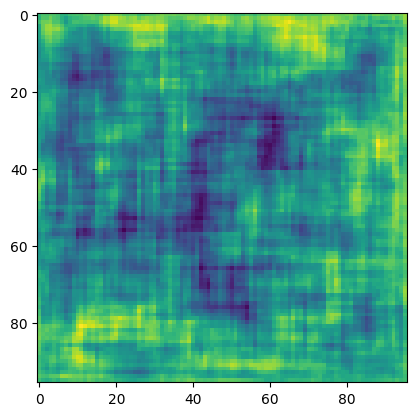

In [ ]:
def save_images(cnt, noise):
    image_array = np.full((
        PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE + PREVIEW_MARGIN)),
        PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE + PREVIEW_MARGIN)), 3),
        255, dtype=np.uint8)

    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE + 16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE + 16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE, c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
            image_count += 1

    output_path = os.path.join(DATA_PATH, 'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    filename = os.path.join(output_path, f"train-{cnt}.jpg")
    im = Image.fromarray(image_array)
    im.save(filename)



generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50042504]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
@tf.function  # TensorFlow의 @tf.function 데코레이터를 함수 위에 사용하면, 해당 함수는 TensorFlow 그래프로 변환
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator.trainable_variables))
  return gen_loss,disc_loss

# 학습 및 결과

Epoch 1, gen loss=2.150499105453491,disc loss=0.4950009286403656, {hms_string(epoch_elapsed)}
1/1 [==============================] - 1s 1s/step
Epoch 2, gen loss=2.2963967323303223,disc loss=0.8718305230140686, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 3, gen loss=1.9386600255966187,disc loss=1.067914366722107, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 4, gen loss=2.0048677921295166,disc loss=0.7516434192657471, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 19ms/step
Epoch 5, gen loss=2.140127658843994,disc loss=0.8218635320663452, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 6, gen loss=2.3787221908569336,disc loss=0.9257758855819702, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 7, gen loss=2.5790231227874756,disc loss=0.4923355281352997, {hms_string(epoch_elapsed)}
1/1 [=======================

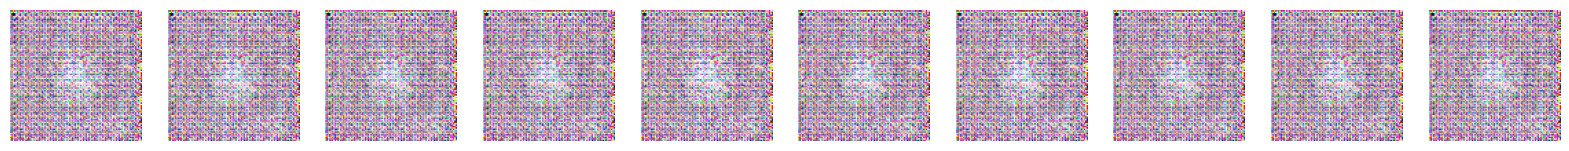

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')
train(train_dataset, 100)




# Generator 모델 저장
generator_weights_path = '/content/gdrive/MyDrive/Vision_data/training_data_96_96.npy'
generator.save_weights(generator_weights_path)

# Generator 모델 불러오기
loaded_generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
generator_weights_path = '/content/gdrive/MyDrive/Vision_data/training_data_96_96.npy'
loaded_generator.load_weights(generator_weights_path)

# 랜덤 노이즈 생성
num_images_to_generate = 10
noise = tf.random.normal([num_images_to_generate, SEED_SIZE])

# 이미지 생성
generated_images = loaded_generator.predict(noise)

# 생성된 이미지 시각화
fig, axs = plt.subplots(1, num_images_to_generate, figsize=(20, 20))
for i in range(num_images_to_generate):
    axs[i].imshow(generated_images[i] * 0.5 + 0.5)  # 생성된 이미지는 -1에서 1 사이의 값이므로, 0~1 사이로 스케일링
    axs[i].axis('off')
plt.show()


Epoch 1, gen loss=11.23392105102539,disc loss=0.00011069932952523232, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 2, gen loss=11.430525779724121,disc loss=5.8992580306949094e-05, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 19ms/step
Epoch 3, gen loss=11.286612510681152,disc loss=0.00010136217315448448, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 4, gen loss=11.3872709274292,disc loss=7.649456529179588e-05, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 5, gen loss=11.483017921447754,disc loss=7.386876677628607e-05, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 24ms/step
Epoch 6, gen loss=11.620926856994629,disc loss=6.572138954652473e-05, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 7, gen loss=11.578438758850098,disc loss=0.00016290816711261868, {hms_string(epoch_elapsed)}
1

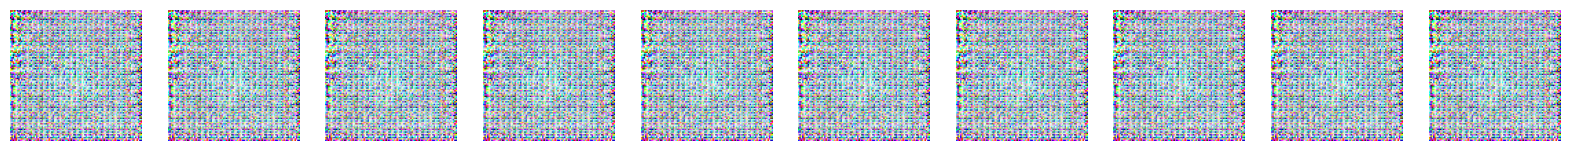

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')
train(train_dataset, 150)




# Generator 모델 저장
generator_weights_path = '/content/gdrive/MyDrive/Vision_data/training_data_96_96.npy'
generator.save_weights(generator_weights_path)

# Generator 모델 불러오기
loaded_generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
generator_weights_path = '/content/gdrive/MyDrive/Vision_data/training_data_96_96.npy'
loaded_generator.load_weights(generator_weights_path)

# 랜덤 노이즈 생성
num_images_to_generate = 10
noise = tf.random.normal([num_images_to_generate, SEED_SIZE])

# 이미지 생성
generated_images = loaded_generator.predict(noise)

# 생성된 이미지 시각화
fig, axs = plt.subplots(1, num_images_to_generate, figsize=(20, 20))
for i in range(num_images_to_generate):
    axs[i].imshow(generated_images[i] * 0.5 + 0.5)  # 생성된 이미지는 -1에서 1 사이의 값이므로, 0~1 사이로 스케일링
    axs[i].axis('off')
plt.show()


Epoch 1, gen loss=16.24999237060547,disc loss=1.123198785535351e-06, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 2, gen loss=16.385883331298828,disc loss=8.894537586456863e-07, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 3, gen loss=16.401395797729492,disc loss=1.1061405302825733e-06, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 4, gen loss=16.32855224609375,disc loss=1.482324023527326e-06, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 5, gen loss=16.397449493408203,disc loss=9.591614116288838e-07, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 6, gen loss=16.28049659729004,disc loss=1.3830062925990205e-06, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 7, gen loss=16.3963623046875,disc loss=1.2996514442420448e-06, {hms_string(epoch_elapsed)}
1/1 

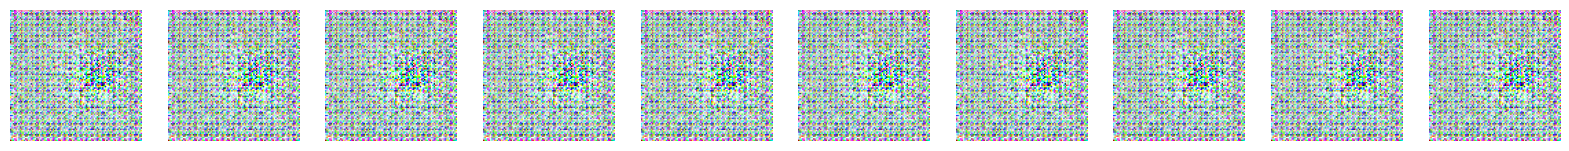

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')
train(train_dataset, 300)




# Generator 모델 저장
generator_weights_path = '/content/gdrive/MyDrive/Vision_data/training_data_96_96.npy'
generator.save_weights(generator_weights_path)

# Generator 모델 불러오기
loaded_generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
generator_weights_path = '/content/gdrive/MyDrive/Vision_data/training_data_96_96.npy'
loaded_generator.load_weights(generator_weights_path)

# 랜덤 노이즈 생성
num_images_to_generate = 10
noise = tf.random.normal([num_images_to_generate, SEED_SIZE])

# 이미지 생성
generated_images = loaded_generator.predict(noise)

# 생성된 이미지 시각화
fig, axs = plt.subplots(1, num_images_to_generate, figsize=(20, 20))
for i in range(num_images_to_generate):
    axs[i].imshow(generated_images[i] * 0.5 + 0.5)  # 생성된 이미지는 -1에서 1 사이의 값이므로, 0~1 사이로 스케일링
    axs[i].axis('off')
plt.show()


Epoch 1, gen loss=20.202566146850586,disc loss=1.1089548834775087e-08, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 23ms/step
Epoch 2, gen loss=20.116092681884766,disc loss=1.071240784966676e-08, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 24ms/step
Epoch 3, gen loss=20.148658752441406,disc loss=1.3068808257798992e-08, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 23ms/step
Epoch 4, gen loss=20.05760383605957,disc loss=1.3849867919191183e-08, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 25ms/step
Epoch 5, gen loss=20.142780303955078,disc loss=1.3177828606103503e-08, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 23ms/step
Epoch 6, gen loss=20.23509979248047,disc loss=1.50127483777851e-08, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 23ms/step
Epoch 7, gen loss=20.140188217163086,disc loss=9.401113665319372e-09, {hms_string(epoch_elapsed)}
1

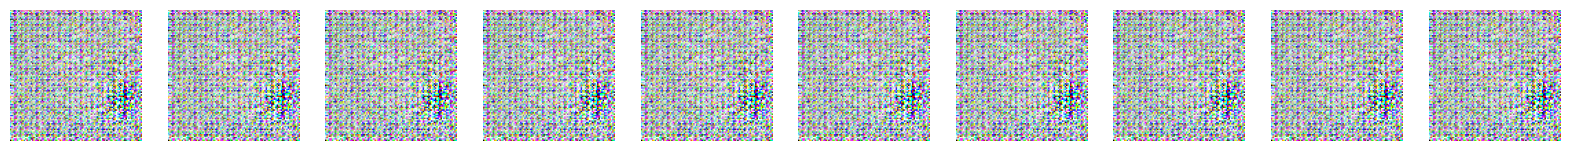

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')
train(train_dataset, 500)




# Generator 모델 저장
generator_weights_path = '/content/gdrive/MyDrive/Vision_data/training_data_96_96.npy'
generator.save_weights(generator_weights_path)

# Generator 모델 불러오기
loaded_generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
generator_weights_path = '/content/gdrive/MyDrive/Vision_data/training_data_96_96.npy'
loaded_generator.load_weights(generator_weights_path)

# 랜덤 노이즈 생성
num_images_to_generate = 10
noise = tf.random.normal([num_images_to_generate, SEED_SIZE])

# 이미지 생성
generated_images = loaded_generator.predict(noise)

# 생성된 이미지 시각화
fig, axs = plt.subplots(1, num_images_to_generate, figsize=(20, 20))
for i in range(num_images_to_generate):
    axs[i].imshow(generated_images[i] * 0.5 + 0.5)  # 생성된 이미지는 -1에서 1 사이의 값이므로, 0~1 사이로 스케일링
    axs[i].axis('off')
plt.show()


Epoch 1, gen loss=23.174222946166992,disc loss=6.301638100225659e-10, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 19ms/step
Epoch 2, gen loss=22.971952438354492,disc loss=8.616186653043201e-10, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 3, gen loss=23.126001358032227,disc loss=7.229600251790202e-10, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 20ms/step
Epoch 4, gen loss=23.14597511291504,disc loss=7.137494484332763e-10, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 19ms/step
Epoch 5, gen loss=22.99224853515625,disc loss=1.3353070871247041e-09, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 6, gen loss=23.033287048339844,disc loss=6.884372516502424e-10, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 21ms/step
Epoch 7, gen loss=22.900814056396484,disc loss=9.353517960164481e-10, {hms_string(epoch_elapsed)}
1/1

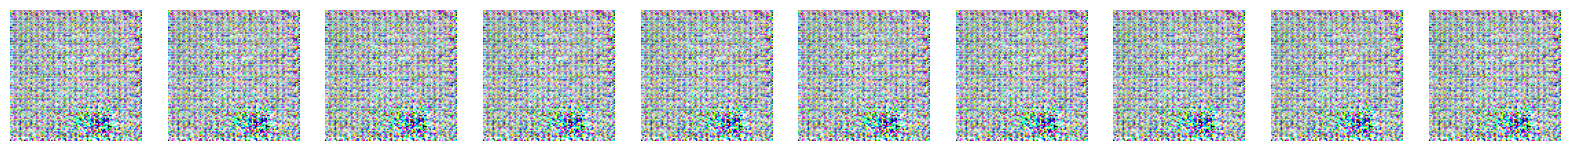

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')
train(train_dataset, 1000)




# Generator 모델 저장
generator_weights_path = '/content/gdrive/MyDrive/Vision_data/training_data_96_96.npy'
generator.save_weights(generator_weights_path)

# Generator 모델 불러오기
loaded_generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
generator_weights_path = '/content/gdrive/MyDrive/Vision_data/training_data_96_96.npy'
loaded_generator.load_weights(generator_weights_path)

# 랜덤 노이즈 생성
num_images_to_generate = 10
noise = tf.random.normal([num_images_to_generate, SEED_SIZE])

# 이미지 생성
generated_images = loaded_generator.predict(noise)

# 생성된 이미지 시각화
fig, axs = plt.subplots(1, num_images_to_generate, figsize=(20, 20))
for i in range(num_images_to_generate):
    axs[i].imshow(generated_images[i] * 0.5 + 0.5)  # 생성된 이미지는 -1에서 1 사이의 값이므로, 0~1 사이로 스케일링
    axs[i].axis('off')
plt.show()
